# Money Mules (детекция «дропперов»)

В этом проекте я анализирую транзакционную активность клиентов крупного банка, чтобы выявлять счета, которые могут использоваться как «дропперские» (Money Mules). Такие клиенты предоставляют свои счета для транзита украденных средств и создают серьёзные риски как с точки зрения регуляторных требований, так и с точки зрения репутации банка.

Классический rules-based подход (фиксированные правила) порождает слишком много ложных срабатываний и приводит к блокировке добросовестных клиентов. В проекте я использую поведенческие данные, чтобы лучше отделить потенциальных «дропперов» от обычных пользователей.

Цель проекта:
    
- Провести разведочный анализ данных (EDA) по транзакционной активности клиентов.
- Выявить отличия в поведении потенциальных «дропперов» (Is_Mule = 1) по сравнению с обычными клиентами (Is_Mule = 0).
- Сформулировать выводы и гипотезы для последующего построения модели детекции Money Mules.

В работе я использую данные о возрасте счета, объёмах и частоте транзакций, а также об остатках на конец дня.

Классы в выборке несбалансированы: подозрительных клиентов существенно меньше, чем добросовестных. Это нужно учитывать при выборе метрик и подходов к оценке качества моделей.

## 1. Загрузка данных и первичный осмотр

**Import numpy и pandas**

In [8]:
import numpy as np
import pandas as pd

**Импортирую библиотек визуализации**

Подключаю инструменты для визуального анализа распределений и взаимосвязей в данных (matplotlib, seaborn). Команда `%matplotlib inline` позволяет отображать графики прямо в ноутбуке.

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**Прочитать CSV-файл как DataFrame с именем df**

In [161]:
df = pd.read_csv('money_mule_dataset.csv')

In [58]:
df.head()

,Customer_ID,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance,Is_Mule
0,MULE_1372,55.0,52097.27,11.0,1.0,107.47,1.0
1,CUST_26636,945.0,1471.92,9221.0,0.0,7302.31,0.0
2,CUST_9210,2952.0,1721.02,2274.0,0.0,3616.30,0.0
3,CUST_13653,2911.0,1570.88,9838.0,0.0,3827.85,0.0
4,CUST_23363,1136.0,1971.88,3343.0,0.0,4122.76,0.0


**Проверить info() по df**

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_ID                 49515 non-null  object 
 1   Account_Age_Days            49491 non-null  float64
 2   Transaction_Volume_USD      49471 non-null  float64
 3   Avg_Time_Between_Trans_Min  49539 non-null  float64
 4   Flags_Last_6M               49480 non-null  float64
 5   Avg_End_Day_Balance         49466 non-null  float64
 6   Is_Mule                     49523 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.7+ MB


In [33]:
df.shape

(50000, 7)

(50000, 7)

**Определяю, в каких столбцах и сколько пропущенных значений.**

In [62]:
df.isnull().sum()

Customer_ID                   485
Account_Age_Days              509
Transaction_Volume_USD        529
Avg_Time_Between_Trans_Min    461
Flags_Last_6M                 520
Avg_End_Day_Balance           534
Is_Mule                       477
dtype: int64

Customer_ID                   485
Account_Age_Days              509
Transaction_Volume_USD        529
Avg_Time_Between_Trans_Min    461
Flags_Last_6M                 520
Avg_End_Day_Balance           534
Is_Mule                       477
dtype: int64

## 2. Базовая описательная статистика

**Получаю общую описательную статистику по числовым признакам.**

In [64]:
df.describe()

,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance,Is_Mule
count,49491.000000,49471.000000,49539.000000,49480.000000,49466.000000,49523.000000
mean,1417.342971,11370.293603,4024.368457,0.119038,6239.109908,0.050098
std,841.009039,19355.028693,3253.771664,0.399753,4464.139755,0.218149
min,1.000000,109.490000,1.000000,0.000000,0.030000,0.000000
25%,715.000000,1753.835000,691.000000,0.000000,3970.402500,0.000000
50%,1387.000000,2155.880000,3781.000000,0.000000,5212.235000,0.000000
75%,2084.000000,2760.890000,6874.500000,0.000000,6656.327500,0.000000
max,2999.000000,98015.150000,9999.000000,3.000000,32321.590000,1.000000


,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance,Is_Mule
count,49491.000000,49471.000000,49539.000000,49480.000000,49466.000000,49523.000000
mean,1417.342971,11370.293603,4024.368457,0.119038,6239.109908,0.050098
std,841.009039,19355.028693,3253.771664,0.399753,4464.139755,0.218149
min,1.000000,109.490000,1.000000,0.000000,0.030000,0.000000
25%,715.000000,1753.835000,691.000000,0.000000,3970.402500,0.000000
50%,1387.000000,2155.880000,3781.000000,0.000000,5212.235000,0.000000
75%,2084.000000,2760.890000,6874.500000,0.000000,6656.327500,0.000000
max,2999.000000,98015.150000,9999.000000,3.000000,32321.590000,1.000000


**Анализ целевого признака Is_Mule**

Смотрю распределение целевого признака `Is_Mule` (количество и доли классов).

In [123]:
df1 = df['Is_Mule'].value_counts(dropna= False)
df1

Is_Mule
0.0    47042
1.0     2481
NaN      477
Name: count, dtype: int64

Is_Mule
0.0    47042
1.0     2481
NaN      477
Name: count, dtype: int64

In [68]:
df['Is_Mule'].value_counts(normalize= True)

Is_Mule
0.0    0.949902
1.0    0.050098
Name: proportion, dtype: float64

Is_Mule
0.0    0.94084
1.0    0.04962
NaN    0.00954
Name: proportion, dtype: float64

**Визуализация распределения классов**

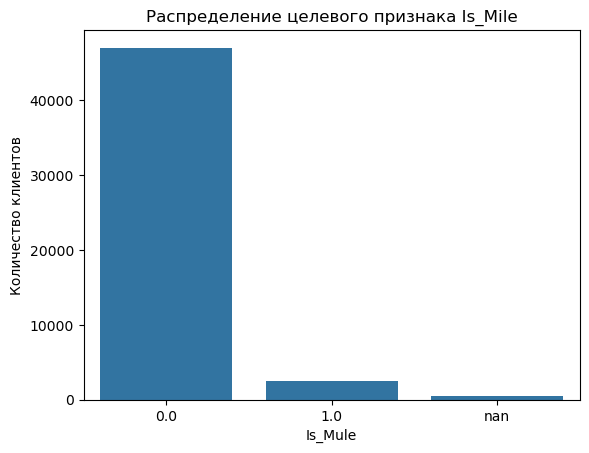

In [119]:
order = ['0.0', '1.0', 'nan']

sns.countplot(data=df, x= df['Is_Mule'].astype('object').fillna('nan'), order= order)
plt.title("Распределение целевого признака Is_Mile")
plt.ylabel('Количество клиентов')

plt.show()

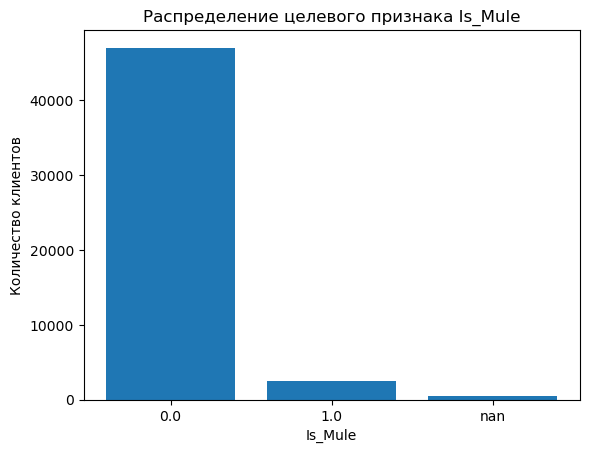

## 3. Очистка целевого признака

**Удаляю строки с пропусками в `Is_Mule`**

In [12]:
# пересохранить как df

In [167]:
df = df[df['Is_Mule'].notna()]

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49523 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_ID                 49043 non-null  object 
 1   Account_Age_Days            49023 non-null  float64
 2   Transaction_Volume_USD      49001 non-null  float64
 3   Avg_Time_Between_Trans_Min  49067 non-null  float64
 4   Flags_Last_6M               49009 non-null  float64
 5   Avg_End_Day_Balance         48993 non-null  float64
 6   Is_Mule                     49523 non-null  float64
dtypes: float64(6), object(1)
memory usage: 3.0+ MB


<class 'pandas.core.frame.DataFrame'>
Index: 49523 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_ID                 49043 non-null  object 
 1   Account_Age_Days            49023 non-null  float64
 2   Transaction_Volume_USD      49001 non-null  float64
 3   Avg_Time_Between_Trans_Min  49067 non-null  float64
 4   Flags_Last_6M               49009 non-null  float64
 5   Avg_End_Day_Balance         48993 non-null  float64
 6   Is_Mule                     49523 non-null  float64
dtypes: float64(6), object(1)
memory usage: 3.0+ MB


**Привожу столбец `Is_Mule` к типу `int` (0 или 1).**

In [195]:
df['Is_Mule'] = df['Is_Mule'].astype(int)

df['Is_Mule'].dtype

dtype('int32')

0        1
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Is_Mule, Length: 49523, dtype: int32

**Перепроверяю баланс классов после очистки**

In [201]:
df['Is_Mule'].value_counts(normalize= True)

Is_Mule
0    0.949902
1    0.050098
Name: proportion, dtype: float64

Is_Mule
0    0.949902
1    0.050098
Name: proportion, dtype: float64

**Выбор числовых признаков для анализа**

Создаю список основных числовых признаков (без ID и таргета) для дальнейшего EDA.

In [207]:
df.head(2)

,Customer_ID,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance,Is_Mule
0,MULE_1372,55.0,52097.27,11.0,1.0,107.47,1
1,CUST_26636,945.0,1471.92,9221.0,0.0,7302.31,0


In [211]:
list1 = ['Account_Age_Days',
         'Transaction_Volume_USD',
         'Avg_Time_Between_Trans_Min',
         'Flags_Last_6M',
         'Avg_End_Day_Balance']

list1

['Account_Age_Days',
 'Transaction_Volume_USD',
 'Avg_Time_Between_Trans_Min',
 'Flags_Last_6M',
 'Avg_End_Day_Balance']

['Account_Age_Days',
 'Transaction_Volume_USD',
 'Avg_Time_Between_Trans_Min',
 'Flags_Last_6M',
 'Avg_End_Day_Balance']

**Описательная статистика по ключевым числовым признакам**

Вывожу статистику только по выбранным числовым признакам.

In [215]:
df_clean = df[list1]

In [221]:
df_clean.describe()

,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance
count,49023.000000,49001.000000,49067.000000,49009.000000,48993.000000
mean,1418.189034,11373.568486,4023.933805,0.118937,6239.112066
std,841.335219,19356.834045,3254.144185,0.399756,4465.087121
min,1.000000,109.490000,1.000000,0.000000,0.030000
25%,716.000000,1753.700000,690.000000,0.000000,3969.460000
50%,1388.000000,2155.670000,3781.000000,0.000000,5212.100000
75%,2086.000000,2761.430000,6874.000000,0.000000,6657.280000
max,2999.000000,98015.150000,9999.000000,3.000000,32321.590000


,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance
count,49023.000000,49001.000000,49067.000000,49009.000000,48993.000000
mean,1418.189034,11373.568486,4023.933805,0.118937,6239.112066
std,841.335219,19356.834045,3254.144185,0.399756,4465.087121
min,1.000000,109.490000,1.000000,0.000000,0.030000
25%,716.000000,1753.700000,690.000000,0.000000,3969.460000
50%,1388.000000,2155.670000,3781.000000,0.000000,5212.100000
75%,2086.000000,2761.430000,6874.000000,0.000000,6657.280000
max,2999.000000,98015.150000,9999.000000,3.000000,32321.590000


## 4. Univariate EDA: распределения признаков

**Строю гистограммы для каждого числового признака, чтобы увидеть форму распределения и возможные выбросы.**

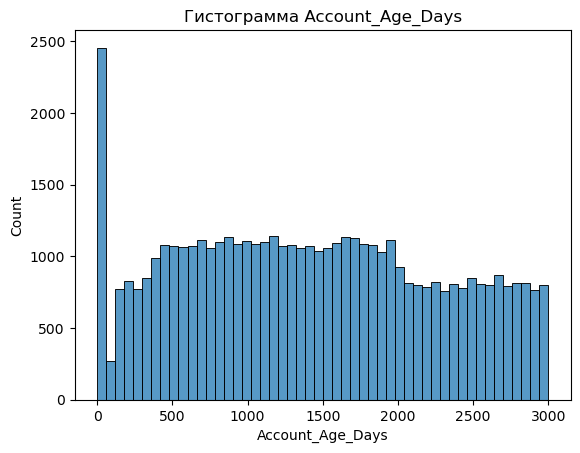

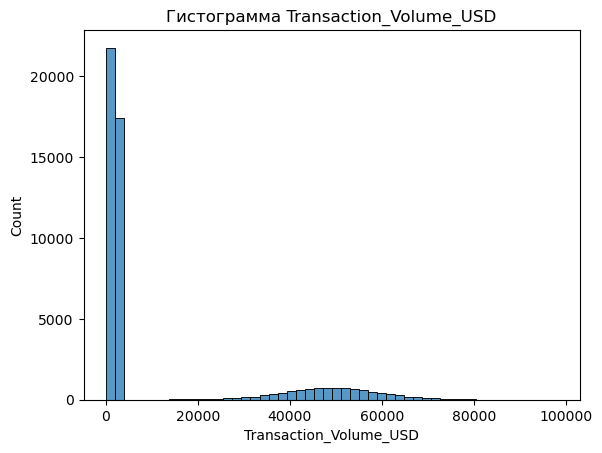

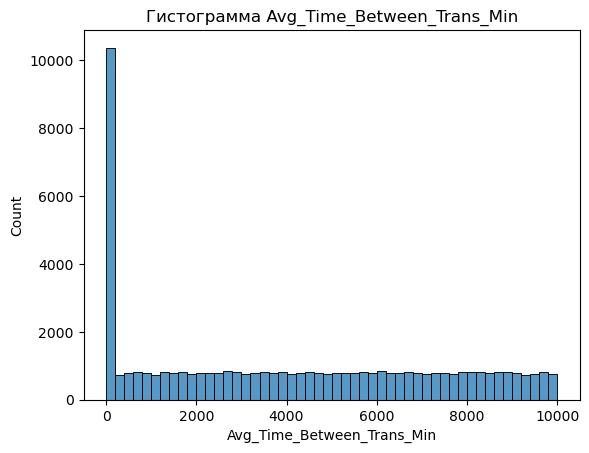

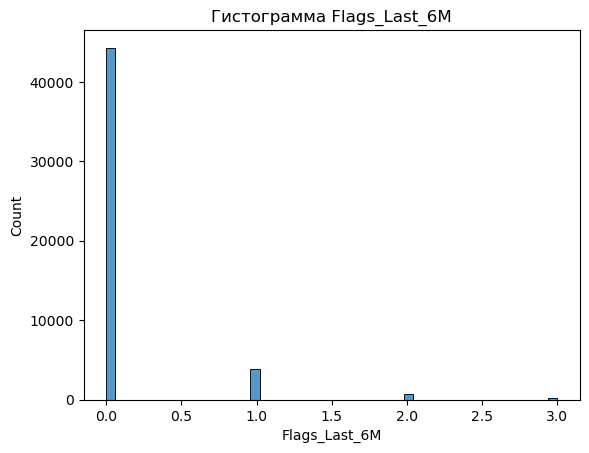

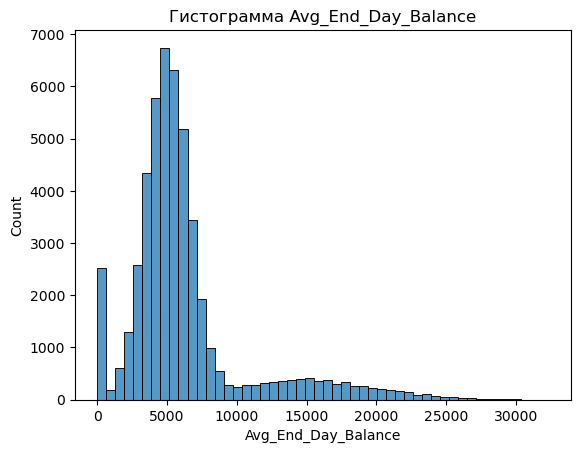

In [235]:
for col in list1:
    sns.histplot(df[col], bins=50, kde=False)
    plt.title(f'Гистограмма {col}')
    plt.show()

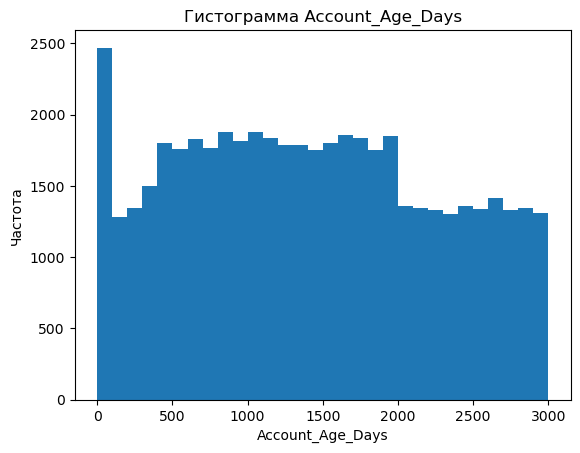

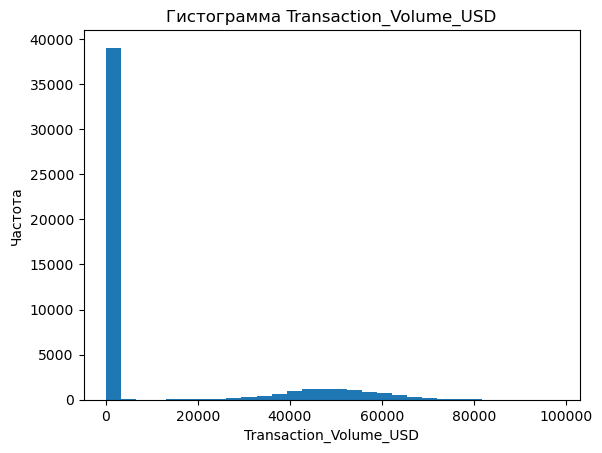

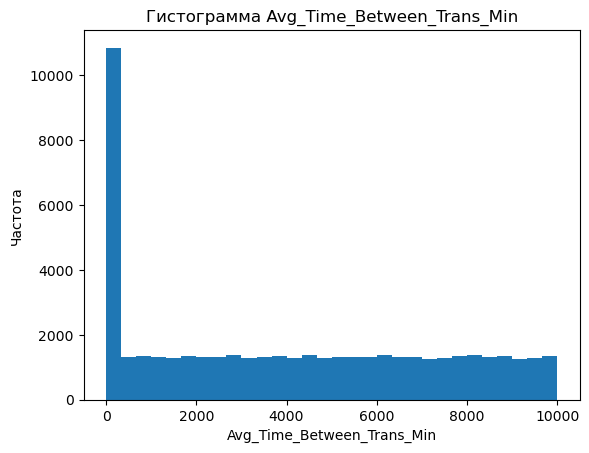

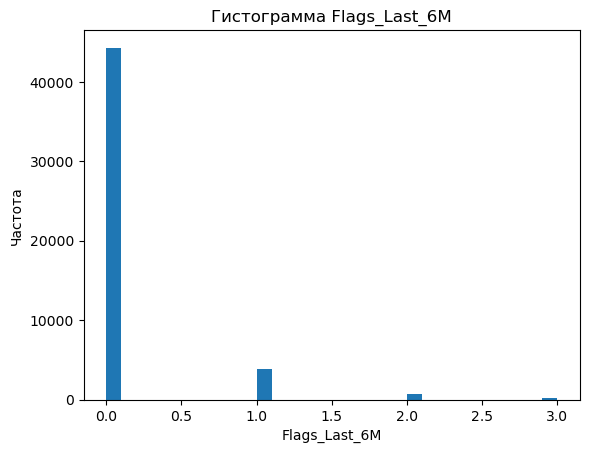

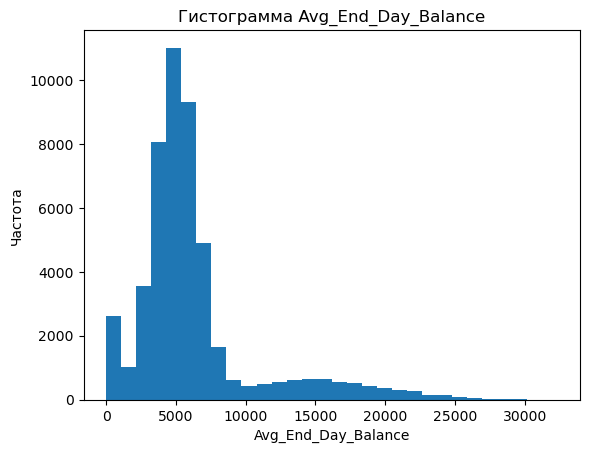

**Boxplot для выявления выбросов**

Строю boxplot для каждого числового признака, чтобы увидеть выбросы.

In [219]:
df_clean.head()

,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance
0,55.0,52097.27,11.0,1.0,107.47
1,945.0,1471.92,9221.0,0.0,7302.31
2,2952.0,1721.02,2274.0,0.0,3616.30
3,2911.0,1570.88,9838.0,0.0,3827.85
4,1136.0,1971.88,3343.0,0.0,4122.76


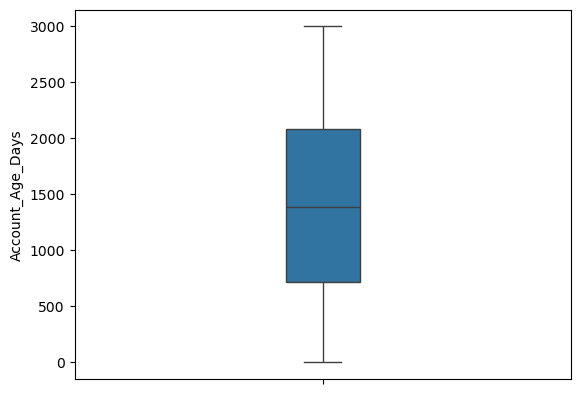

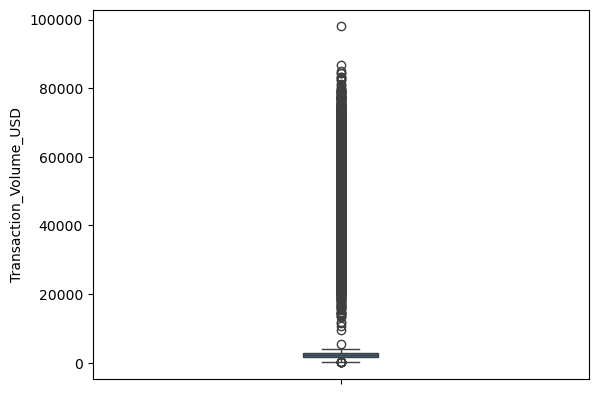

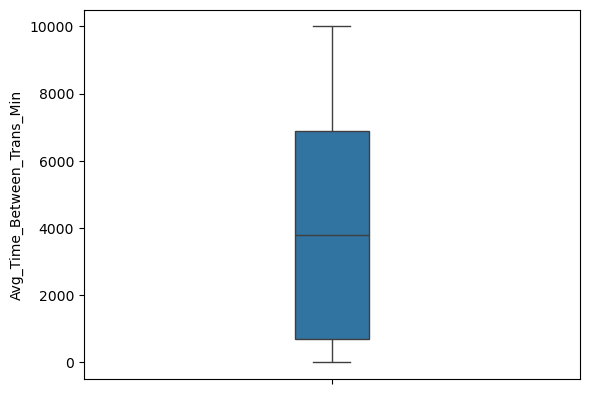

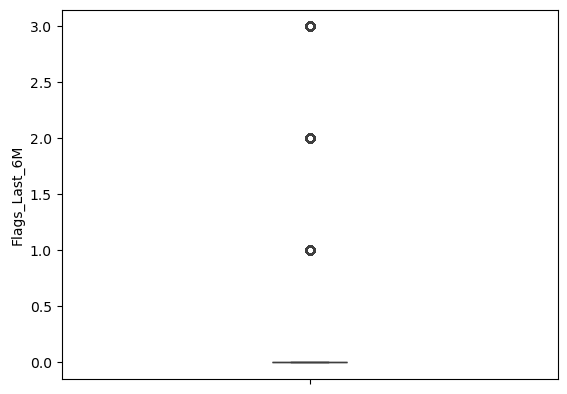

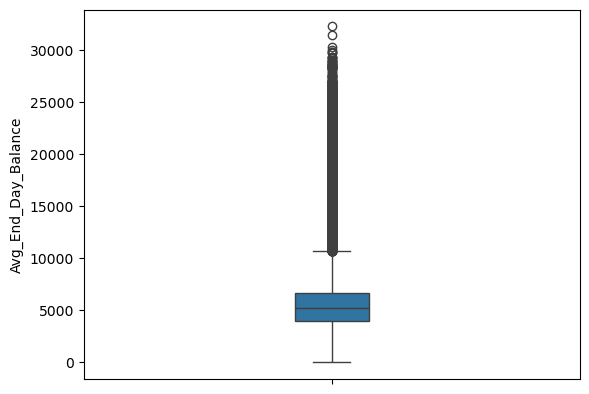

In [271]:
for x in list1:
    sns.boxplot(df[x],width=0.15)
    plt.show()

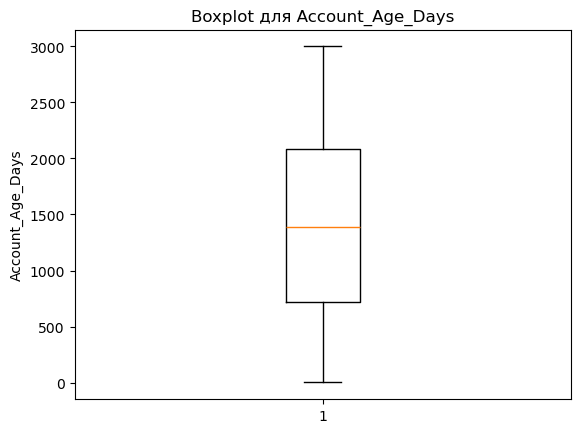

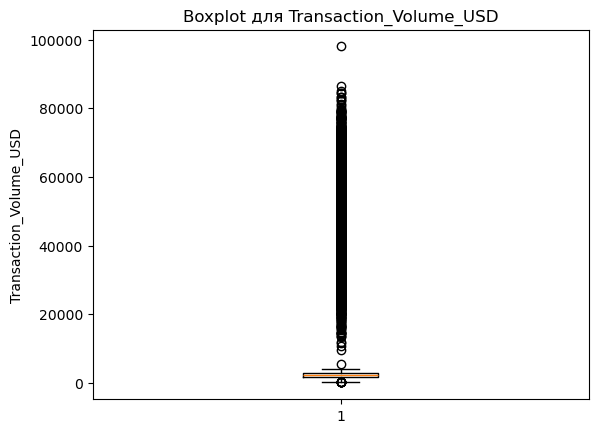

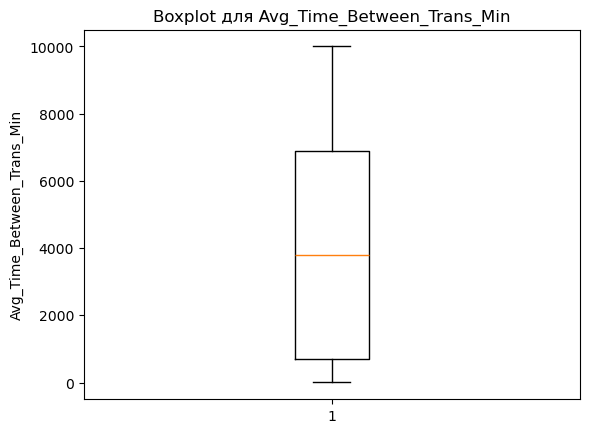

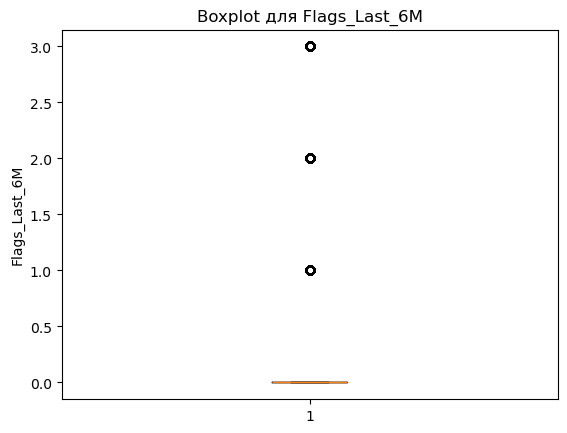

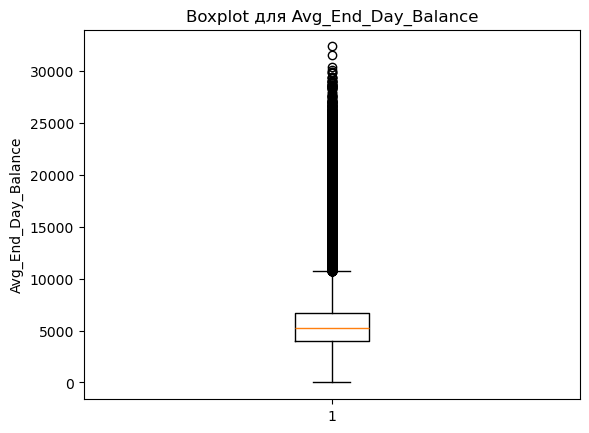

## 5. Target-aware EDA: сравнение признаков по классам Is_Mule

Сравниваю описательную статистику по каждому признаку в разрезе классов: `Is_Mule = 0` и `Is_Mule = 1`.


In [371]:
list2 = df_clean.columns
list2

Index(['Account_Age_Days', 'Transaction_Volume_USD',
       'Avg_Time_Between_Trans_Min', 'Flags_Last_6M', 'Avg_End_Day_Balance'],
      dtype='object')

In [439]:
for x in list2:
    print(f"=== {x} ===")
    display(df.groupby('Is_Mule').describe()[x])

=== Account_Age_Days ===


,count,mean,std,min,25%,50%,75%,max
Is_Mule,,,,,,,,
0,46567.0,1491.404192,798.851152,100.0,818.00,1457.0,2133.0,2999.0
1,2456.0,29.992671,17.100159,1.0,14.75,30.5,45.0,59.0


=== Transaction_Volume_USD ===


,count,mean,std,min,25%,50%,75%,max
Is_Mule,,,,,,,,
0,46551.0,9591.603555,17988.880421,109.49,1731.10,2114.730,2608.915,98015.15
1,2450.0,45231.629502,11777.027052,9616.65,37393.26,45261.595,53004.925,84973.92


=== Avg_Time_Between_Trans_Min ===


,count,mean,std,min,25%,50%,75%,max
Is_Mule,,,,,,,,
0,46604.0,4236.196872,3201.798312,2.0,1167.0,4093.0,7030.0,9999.0
1,2463.0,7.568413,4.020673,1.0,4.0,8.0,11.0,14.0


=== Flags_Last_6M ===


,count,mean,std,min,25%,50%,75%,max
Is_Mule,,,,,,,,
0,46558.0,0.083659,0.305218,0.0,0.0,0.0,0.0,2.0
1,2451.0,0.789066,0.976446,0.0,0.0,0.0,1.0,3.0


=== Avg_End_Day_Balance ===


,count,mean,std,min,25%,50%,75%,max
Is_Mule,,,,,,,,
0,46535.0,6563.320968,4346.820807,19.36,4181.2300,5329.920,6768.5600,32321.59
1,2458.0,101.170151,48.516646,0.03,65.8125,100.245,134.8375,280.40



=== Account_Age_Days по классам Is_Mule ===


,count,mean,std,min,25%,50%,75%,max
Is_Mule,,,,,,,,
0,46567.0,1491.404192,798.851152,100.0,818.00,1457.0,2133.0,2999.0
1,2456.0,29.992671,17.100159,1.0,14.75,30.5,45.0,59.0



=== Transaction_Volume_USD по классам Is_Mule ===


,count,mean,std,min,25%,50%,75%,max
Is_Mule,,,,,,,,
0,46551.0,9591.603555,17988.880421,109.49,1731.10,2114.730,2608.915,98015.15
1,2450.0,45231.629502,11777.027052,9616.65,37393.26,45261.595,53004.925,84973.92



=== Avg_Time_Between_Trans_Min по классам Is_Mule ===


,count,mean,std,min,25%,50%,75%,max
Is_Mule,,,,,,,,
0,46604.0,4236.196872,3201.798312,2.0,1167.0,4093.0,7030.0,9999.0
1,2463.0,7.568413,4.020673,1.0,4.0,8.0,11.0,14.0



=== Flags_Last_6M по классам Is_Mule ===


,count,mean,std,min,25%,50%,75%,max
Is_Mule,,,,,,,,
0,46558.0,0.083659,0.305218,0.0,0.0,0.0,0.0,2.0
1,2451.0,0.789066,0.976446,0.0,0.0,0.0,1.0,3.0



=== Avg_End_Day_Balance по классам Is_Mule ===


,count,mean,std,min,25%,50%,75%,max
Is_Mule,,,,,,,,
0,46535.0,6563.320968,4346.820807,19.36,4181.2300,5329.920,6768.5600,32321.59
1,2458.0,101.170151,48.516646,0.03,65.8125,100.245,134.8375,280.40


**Средние значения признаков по классам**

Сравниваю средние значения числовых признаков для обычных клиентов и «дропперов».

In [457]:
df.groupby('Is_Mule').mean(numeric_only= True)

,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance
Is_Mule,,,,,
0,1491.404192,9591.603555,4236.196872,0.083659,6563.320968
1,29.992671,45231.629502,7.568413,0.789066,101.170151


,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance
Is_Mule,,,,,
0,1491.404192,9591.603555,4236.196872,0.083659,6563.320968
1,29.992671,45231.629502,7.568413,0.789066,101.170151


## Boxplot по классам

Строю boxplot для каждого признака с разделением по классам `Is_Mule`.

In [502]:
df.head(2)

,Customer_ID,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance,Is_Mule
0,MULE_1372,55.0,52097.27,11.0,1.0,107.47,1
1,CUST_26636,945.0,1471.92,9221.0,0.0,7302.31,0


In [511]:
sns.boxplot(df,width=0.1,y= 'Account_Age_Days', x= 'Is_Mule',palette= 'Set2')

C:\Users\drami\AppData\Local\Temp\ipykernel_18628\287384169.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df,width=0.1,y= 'Account_Age_Days', x= 'Is_Mule',palette= 'Set2')


<Axes: xlabel='Is_Mule', ylabel='Account_Age_Days'>

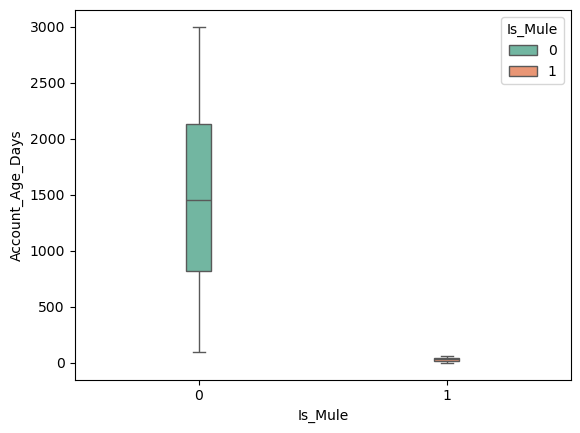

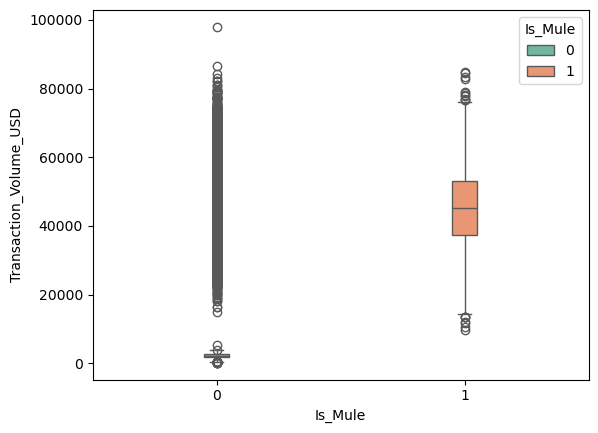

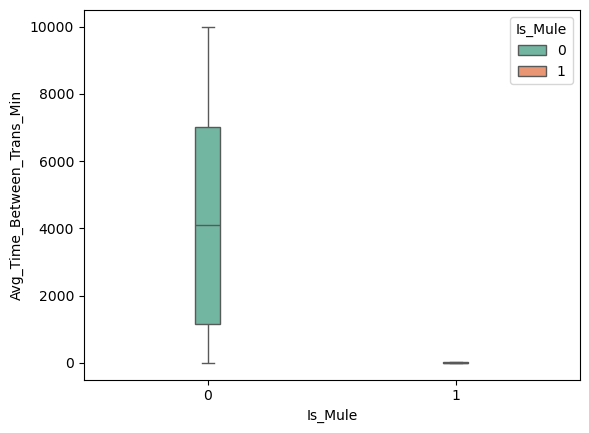

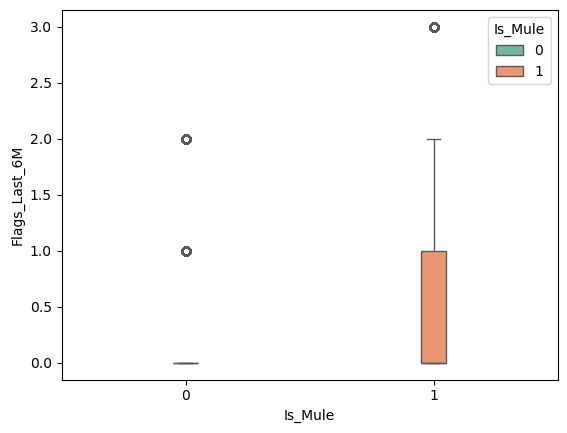

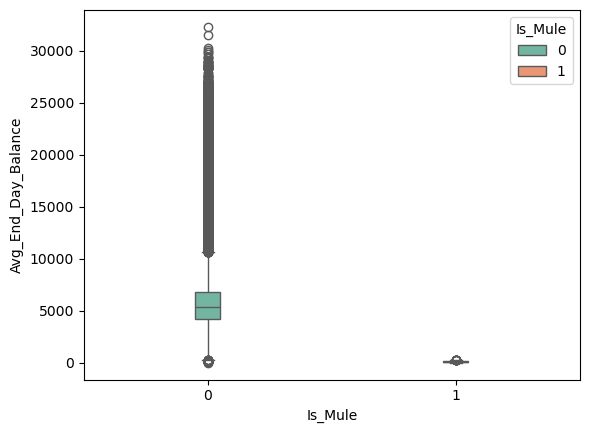

In [517]:
for x in list2:
    sns.boxplot(df,width=0.1,y= x, x= 'Is_Mule',palette= 'Set2', hue= 'Is_Mule')
    plt.show()

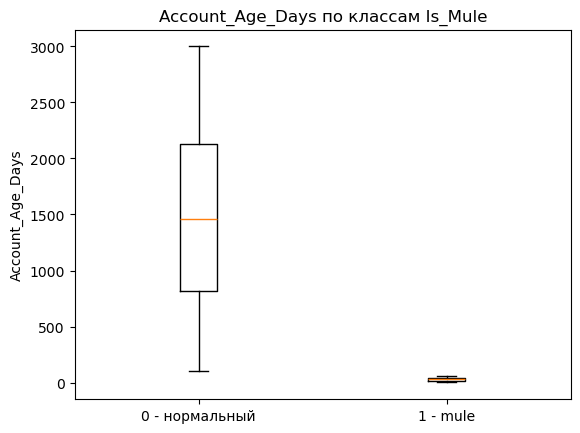

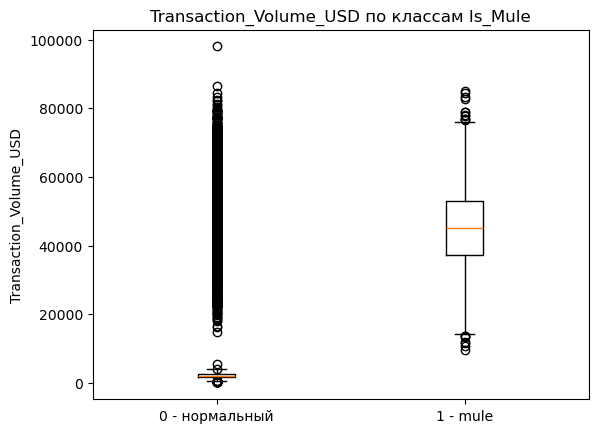

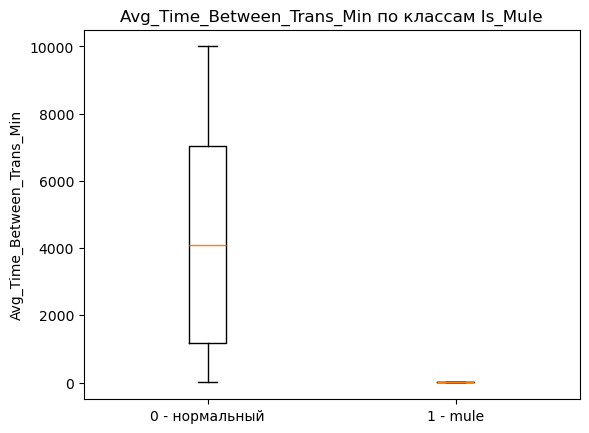

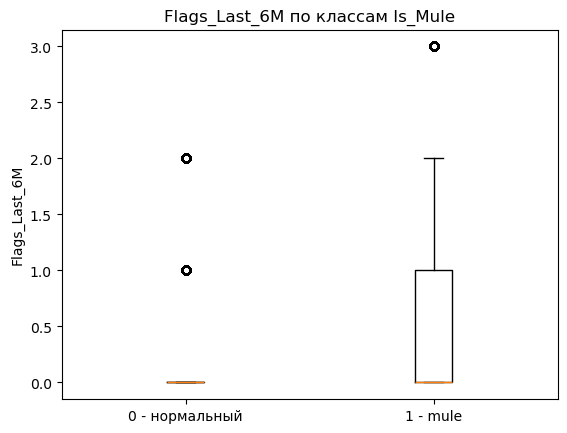

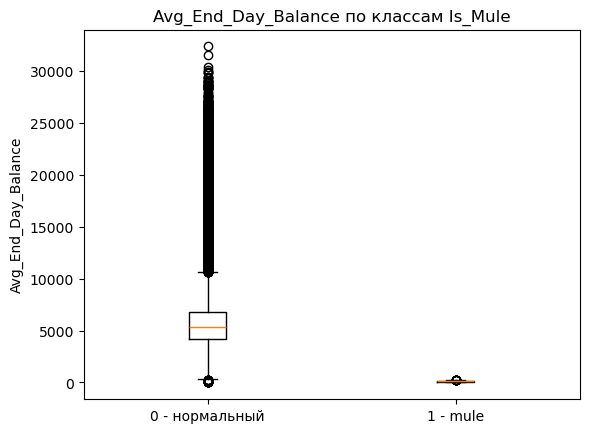

## 6. Корреляционный анализ

Строю корреляционную матрицу для числовых признаков и таргета `Is_Mule`.

In [571]:
list3 = list(df_clean.columns) + ['Is_Mule']
print(list3)


['Account_Age_Days', 'Transaction_Volume_USD', 'Avg_Time_Between_Trans_Min', 'Flags_Last_6M', 'Avg_End_Day_Balance', 'Is_Mule']


In [579]:
df_corr = df[list3].corr()
df_corr

,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance,Is_Mule
Account_Age_Days,1.000000,-0.292533,0.196110,-0.170625,-0.004613,-0.378932
Transaction_Volume_USD,-0.292533,1.000000,-0.597997,0.315675,0.568678,0.401283
Avg_Time_Between_Trans_Min,0.196110,-0.597997,1.000000,-0.210008,-0.340687,-0.283741
Flags_Last_6M,-0.170625,0.315675,-0.210008,1.000000,0.025856,0.384629
Avg_End_Day_Balance,-0.004613,0.568678,-0.340687,0.025856,1.000000,-0.315935
Is_Mule,-0.378932,0.401283,-0.283741,0.384629,-0.315935,1.000000


,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance,Is_Mule
Account_Age_Days,1.000000,-0.292533,0.196110,-0.170625,-0.004613,-0.378932
Transaction_Volume_USD,-0.292533,1.000000,-0.597997,0.315675,0.568678,0.401283
Avg_Time_Between_Trans_Min,0.196110,-0.597997,1.000000,-0.210008,-0.340687,-0.283741
Flags_Last_6M,-0.170625,0.315675,-0.210008,1.000000,0.025856,0.384629
Avg_End_Day_Balance,-0.004613,0.568678,-0.340687,0.025856,1.000000,-0.315935
Is_Mule,-0.378932,0.401283,-0.283741,0.384629,-0.315935,1.000000


**Визуализация корреляционной матрицы**

Отображаю корреляционную матрицу в виде тепловой карты (heatmap).

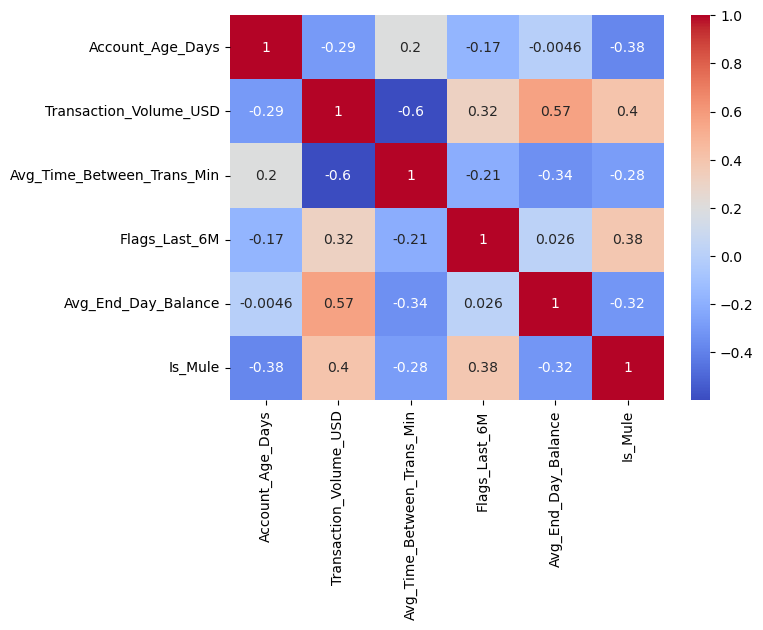

In [595]:
plt.figure(figsize=([7,5]))

sns.heatmap(df_corr,annot= True,cmap='coolwarm')
plt.show()

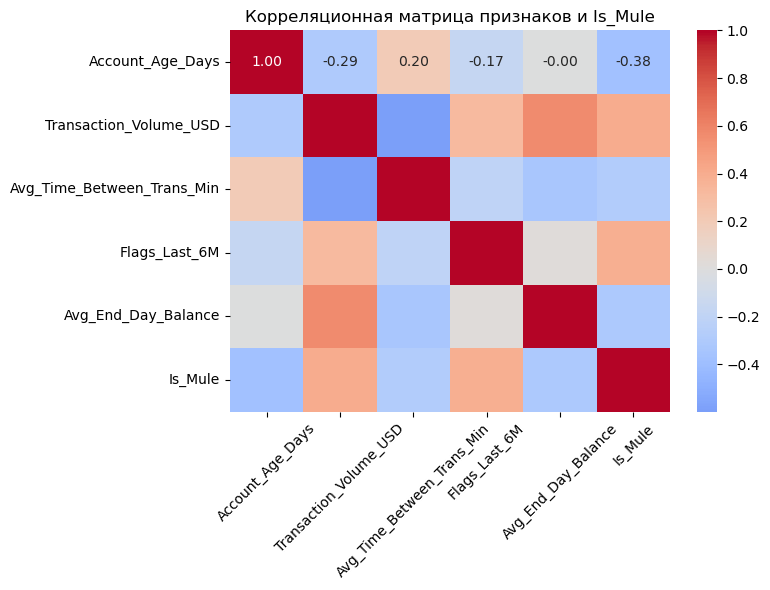

## 7. Взаимосвязи признаков: scatter-графики

Строю scatter-график для пары признаков `Account_Age_Days` и `Transaction_Volume_USD` с выделением классов `Is_Mule`.

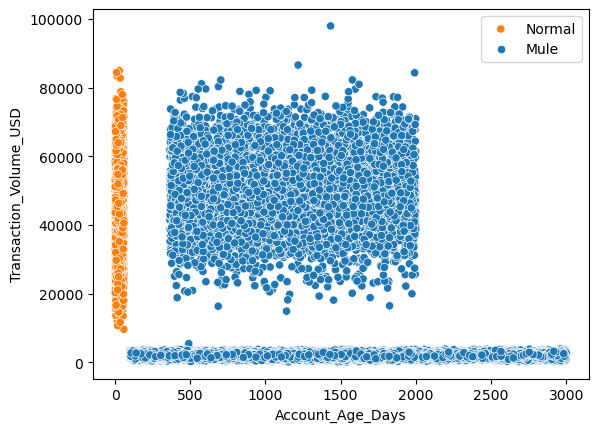

In [609]:
sns.scatterplot(df, x= 'Account_Age_Days', y= 'Transaction_Volume_USD', hue='Is_Mule')
plt.legend(labels=['Normal', 'Mule'])

plt.show()

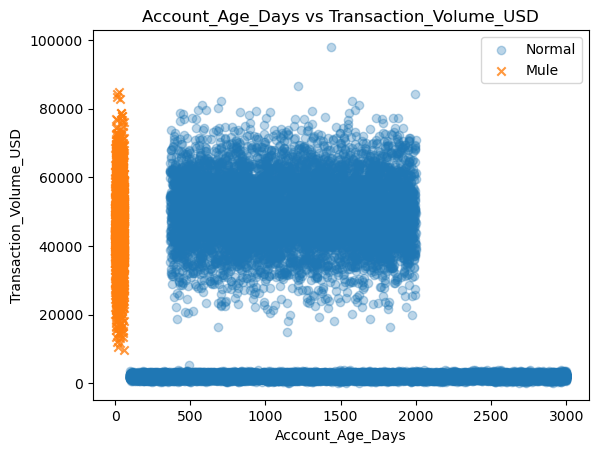

## Взаимосвязь остатка и объёма

Строю scatter-график для пары `Avg_End_Day_Balance` и `Transaction_Volume_USD` с выделением классов.

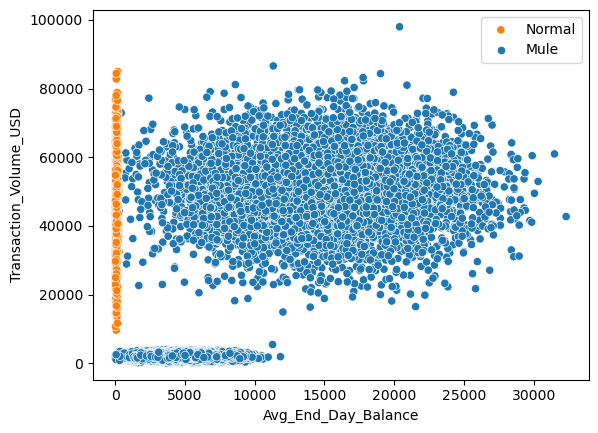

In [611]:
sns.scatterplot(df, x= 'Avg_End_Day_Balance', y= 'Transaction_Volume_USD', hue='Is_Mule')
plt.legend(labels=['Normal', 'Mule'])

plt.show()

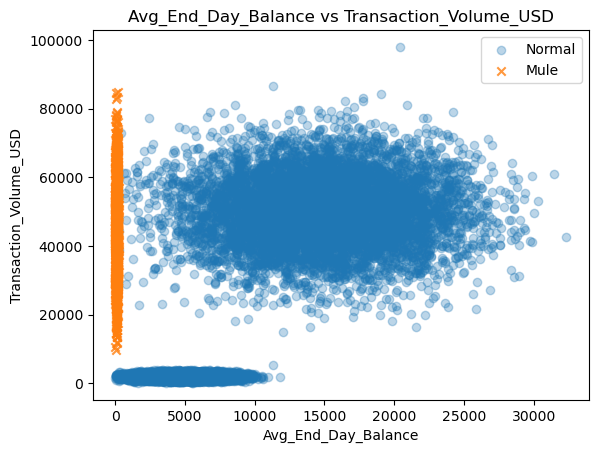

## 8. Обработка пропусков и подготовка данных

Создаю очищенную версию датасета `df_clean`, удалив строки с пропусками в ключевых числовых признаках.

In [623]:
df_clean2 = df_clean.dropna()
df_clean2.shape

(47054, 5)

(47054, 7)

**Приведение типов признаков**

In [627]:
df_clean2['Flags_Last_6M'].value_counts()

Flags_Last_6M
0.0    42516
1.0     3694
2.0      616
3.0      228
Name: count, dtype: int64

Flags_Last_6M
0    42516
1     3694
2      616
3      228
Name: count, dtype: int64

## 9. Создание новых производных признаков

Создаю новые признаки:
- `Volume_per_Day` = `Transaction_Volume_USD` / (`Account_Age_Days` + 1)
- `Balance_to_Volume` = `Avg_End_Day_Balance` / (`Transaction_Volume_USD` + 1)

In [29]:
# Создаём производные признаки

In [653]:
df_clean2.head(2)

,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance,Volume_per_Day,Balance_to_Volume
0,55.0,52097.27,11.0,1.0,107.47,930.308393,0.002063
1,945.0,1471.92,9221.0,0.0,7302.31,1.555941,4.957710


In [651]:
df_clean2['Volume_per_Day'] = df_clean2['Transaction_Volume_USD'] / (df_clean2['Account_Age_Days'] + 1)
df_clean2['Balance_to_Volume'] = df_clean2['Avg_End_Day_Balance'] / (df_clean2['Transaction_Volume_USD'] + 1)

df_clean2[['Volume_per_Day','Balance_to_Volume']].describe()

C:\Users\drami\AppData\Local\Temp\ipykernel_18628\868046472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean2['Volume_per_Day'] = df_clean2['Transaction_Volume_USD'] / (df_clean2['Account_Age_Days'] + 1)
C:\Users\drami\AppData\Local\Temp\ipykernel_18628\868046472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean2['Balance_to_Volume'] = df_clean2['Avg_End_Day_Balance'] / (df_clean2['Transaction_Volume_USD'] + 1)


,Volume_per_Day,Balance_to_Volume
count,47054.000000,4.705400e+04
mean,148.352836,2.214807e+00
std,1018.900506,1.541169e+00
min,0.074481,5.908140e-07
25%,0.947561,1.247200e+00
50%,1.677269,2.201322e+00
75%,6.972659,3.026328e+00
max,34251.325000,3.696628e+01


,Volume_per_Day,Balance_to_Volume
count,47054.000000,4.705400e+04
mean,148.352836,2.214807e+00
std,1018.900506,1.541169e+00
min,0.074481,5.908140e-07
25%,0.947561,1.247200e+00
50%,1.677269,2.201322e+00
75%,6.972659,3.026328e+00
max,34251.325000,3.696628e+01


**Сравнение новых признаков по классам**

Сравниваю распределения `Volume_per_Day` и `Balance_to_Volume` для обычных клиентов и «дропперов».

Is_Mule                             0             1
Volume_per_Day    count  44699.000000  2.355000e+03
                  mean      10.239297  2.769812e+03
                  std       21.835498  3.674918e+03
                  min        0.074481  1.629941e+02
                  25%        0.926370  9.665169e+02
                  50%        1.555805  1.460794e+03
                  75%        4.732601  2.943800e+03
                  max      199.442703  3.425132e+04
Balance_to_Volume count  44699.000000  2.355000e+03
                  mean       2.331368  2.428459e-03
                  std        1.492941  1.468876e-03
                  min        0.002236  5.908140e-07
                  25%        1.470571  1.411069e-03
                  50%        2.275541  2.232787e-03
                  75%        3.080421  3.125641e-03
                  max       36.966281  1.331781e-02